In [12]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Basic usage

In [2]:
# Get file path to audio example
filename = librosa.example('nutcracker')

# Load audio as waveform 'y'
# Store sampling rate as 'sr'
y, sr = librosa.load(filename)

# Run default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

print(f'Estimated tempo: {tempo} bpm')

# Convert frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
print(f"First 10 beat times are at {beat_times[:10]}")

Estimated tempo: 107.666015625 bpm
First 10 beat times are at [1.18421769 1.71827664 2.32199546 2.87927438 3.45977324 4.01705215
 4.59755102 5.13160998 5.7353288  6.29260771]


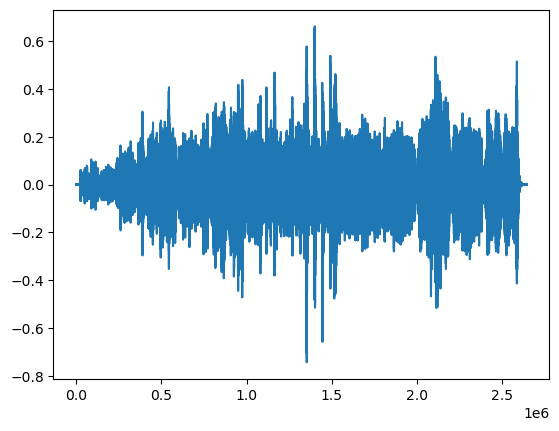

In [6]:
import matplotlib.pyplot as plt
plt.plot(y)
plt.show()

## Advanced usage

In [26]:
# Set hop length at 22050 Hz, 512 samples ~= 23ms
hop_length = 512

# Separate harmonics and percussives into two waveforms
y_harmonic, y_percussive = librosa.effects.hpss(y)

# Beat track on the percussive signal
tempo, beat_frames = librosa.beat.beat_track(y=y_percussive, sr=sr)

# Compute MFCC features from raw signal
# NOTE: MFCC features are Mel-frequency cepstral coefficients
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)

# First order differences -> Slopes between each corresponding column
mfcc_delta = librosa.feature.delta(mfcc)

# Stack and synchronize between beat events
# Using mean values (default) instead of median
beat_mfcc_delta = librosa.util.sync(np.vstack([mfcc, mfcc_delta]), beat_frames)

# Compute chromagram features from harmonic signal
# -> 12 columns with one for each pitch class (C, C#, D, ...)
chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)

# Aggregate chroma features between beat events
# Using median value of each feature between beat frames
beat_chroma = librosa.util.sync(chromagram, beat_frames, aggregate=np.median)

# Finally, stack all beat-synchronous features together
# -> Feature matrix of shape (12 + 13 + 13, #beat_intervals)
beat_features = np.vstack([beat_chroma, beat_mfcc_delta])

In [27]:
beat_chroma.shape

(12, 212)

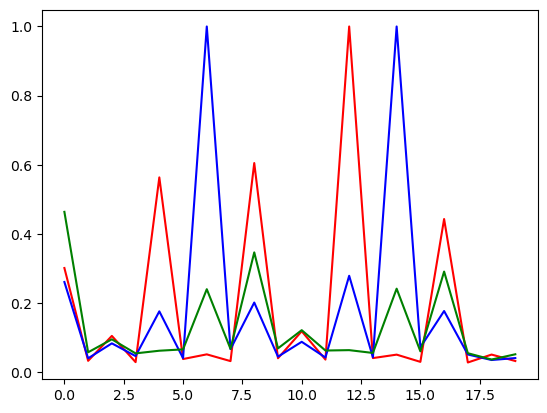

In [29]:
plt.plot(beat_chroma[0, :20], color='red')
plt.plot(beat_chroma[1, :20], color='blue')
plt.plot(beat_chroma[2, :20], color='green')
plt.show()

## Add two signals and write to file

In [39]:
import soundfile as sf

tone = librosa.tone(440, duration=10) / 100 # Reduce loudness
y_first_10 = y[:22050*10]
y_plus_tone = y_first_10 + tone

sf.write('example.wav', y_plus_tone, 22050, subtype='PCM_24')